# Data Science Challenge

## Overview

The focus of this exercise is  on a field within machine learning called [Natural Language Processing](https://en.wikipedia.org/wiki/Natural-language_processing). We can think of this field as the intersection between language, and machine learning. Tasks in this field include automatic translation (Google translate), intelligent personal assistants (Siri), predictive text, and speech recognition for example.

NLP uses many of the same techniques as traditional data science, but also features a number of specialised skills and approaches. There is no expectation that you have any experience with NLP, however, to complete the challenge it will be useful to have the following skills:

- understanding of the python programming language, or similar third generation language.
- understanding of basic machine learning concepts, i.e. supervised learning


### Instructions

1. Create a Kaggle account and `fork` this notebook.
2. Answer each of the provided questions, including your source code as cells in this notebook.
3. Provide us a link to your Kaggle notebook at your convenience.

### Task description

You will be performing a task known as [sentiment analysis](https://en.wikipedia.org/wiki/Sentiment_analysis). Here, the goal is to predict sentiment -- the emotional intent behind a statement -- from text. For example, the sentence: "*This movie was terrible!"* has a negative sentiment, whereas "*loved this cinematic masterpiece*" has a positive sentiment.

To simplify the task, we consider sentiment binary: labels of `1` indicate a sentence has a positive sentiment, and labels of `0` indicate that the sentence has a negative sentiment.

### Dataset

The dataset is split across three files, representing three different sources -- Amazon, Yelp and IMDB. Your task is to build a sentiment analysis model using both the Yelp and IMDB data as your training-set, and test the performance of your model on the Amazon data.

Each file can be found in the `../input` directory, and contains 1000 rows of data. Each row contains a sentence, a `tab` character and then a label -- `0` or `1`. 

**Notes**
- This environment comes with a wide range of ML libraries installed. If you wish to include more, go to the 'Settings' tab and input the `pip install` command as required.
- Suggested libraries: `sklearn` (for machine learning), `pandas` (for loading/processing data).
- As mentioned, you are not expected to have previous experience with this exact task. You are free to refer to external tutorials/resources to assist you. However, you will be asked to justfify the choices you have made -- so make you understand the approach you have taken.

In [1]:
import os
print(os.listdir("../input"))

['readme.txt', 'amazon_cells_labelled.txt', 'yelp_labelled.txt', 'imdb_labelled.txt']


In [2]:
!head "../input/amazon_cells_labelled.txt"

So there is no way for me to plug it in here in the US unless I go by a converter.	0
Good case, Excellent value.	1
Great for the jawbone.	1
Tied to charger for conversations lasting more than 45 minutes.MAJOR PROBLEMS!!	0
The mic is great.	1
I have to jiggle the plug to get it to line up right to get decent volume.	0
If you have several dozen or several hundred contacts, then imagine the fun of sending each of them one by one.	0
If you are Razr owner...you must have this!	1
Needless to say, I wasted my money.	0
What a waste of money and time!.	0


# Tasks
### 1. Read and concatenate data into test and train sets.
### 2. Prepare the data for input into your model.

In [3]:
import os
import random

DATA_PATH = '../input'
LABEL_MAP= {
    1: 'positive',
    0: 'negative'
}

TRAIN_FILES = {'yelp_labelled.txt', 'imdb_labelled.txt'}
TEST_FILES = {'amazon_cells_labelled.txt'}

def iter_instances_at_path(path):
    with open(path, 'rt') as f:
        for i, line in enumerate(f):
            sentence, label = line.split('\t')
            
            # some very basic data norm and validation, break-out if it gets more complicated
            sentence = sentence.strip()
            label = int(label)
            assert sentence
            assert label in LABEL_MAP

            yield {
                'sentence': sentence,
                'label': label,
                'source': {
                    'path': os.path.basename(path),
                    'idx': i
                },
            }

files = TRAIN_FILES.union(TEST_FILES)
items = [i for p in files for i in iter_instances_at_path(os.path.join(DATA_PATH, p))]
print("Read {:d} items from {:d} files...".format(len(items), len(files)))

Read 3000 items from 3 files...


In [4]:
items[:1]

[{'label': 0,
  'sentence': 'So there is no way for me to plug it in here in the US unless I go by a converter.',
  'source': {'idx': 0, 'path': 'amazon_cells_labelled.txt'}}]

In [5]:
import spacy

# use spacy for the low-level cookie-cutter text processing (i.e. tokenization)
# we will also make use of word vectors and dependency parse features
nlp = spacy.load('en_core_web_lg')

def preprocess_item(item):
    item['doc'] = nlp(item['sentence'])
    return item

In [6]:
from tqdm import tqdm_notebook as tqdm
items = [preprocess_item(i) for i in tqdm(items)]

A Jupyter Widget

In [7]:
items[:1]

[{'doc': So there is no way for me to plug it in here in the US unless I go by a converter.,
  'label': 0,
  'sentence': 'So there is no way for me to plug it in here in the US unless I go by a converter.',
  'source': {'idx': 0, 'path': 'amazon_cells_labelled.txt'}}]

#### 2a: Find the ten most frequent words in the training set.

In [8]:
from collections import Counter

In [9]:
# it really depends what we count as a "word"
counts = Counter()
for i in items:
    if i['source']['path'] in TRAIN_FILES:
        counts.update(t.text.lower() for t in i['doc'])
print("Most common tokens:")
counts.most_common(10)

Most common tokens:


[('.', 1729),
 ('the', 1432),
 (',', 1012),
 ('and', 826),
 ('a', 669),
 ('i', 658),
 ('is', 517),
 ('of', 504),
 ('was', 501),
 ('it', 476)]

In [10]:
counts = Counter()
for i in items:
    if i['source']['path'] in TRAIN_FILES:
        for t in i['doc']:
            if not t.is_stop and not t.is_punct and not t.lemma_ in nlp.Defaults.stop_words:
                counts[t.lemma_] += 1
print("Most common non-stop, non-punctuation, lemmatized tokens:")
counts.most_common(10)

Most common non-stop, non-punctuation, lemmatized tokens:


[('-PRON-', 2016),
 ('good', 230),
 ('movie', 212),
 ('film', 189),
 ('food', 127),
 ('bad', 126),
 ('place', 119),
 ('great', 115),
 ('like', 111),
 ('time', 103)]

## Extract features

In [11]:
import numpy

# compute the cosine similarity between a pair of vectors
# we will use this for word-vector features
def sim(a, b):
    res = numpy.dot(a, b) / (numpy.linalg.norm(a) * numpy.linalg.norm(b))
    if numpy.isnan(res):
        return 0.
    return res

In [13]:
DELEX_POS_TAGS = {'PROPN', 'NOUN'}
def delexicalize(doc):
    tks = []
    for t in doc:
        if t.pos_ in DELEX_POS_TAGS:
            if not tks or tks[-1] != t.pos_:
                tks.append(t.pos_)
        else:
            tks.append(t.lemma_)
    return tks

In [14]:
def extract_bag_of_ngrams(item):
    tokens = [t.lemma_.lower() for t in item['doc']]    
    bigrams = ['|'.join(ngram) for ngram in zip(tokens, tokens[1:])]
    for t in set(tokens + bigrams):
        yield t, True

def extract_root_tokens(item):
    for t in item['doc']:
        if t.dep_ == 'ROOT':
            yield t.lemma_, True

def extract_delex_ngrams(item):
    tokens = [t for t in delexicalize(item['doc'])]
    bigrams = ['|'.join(ngram) for ngram in zip(tokens, tokens[1:])]
    for t in set(bigrams):
        yield t, True

from scipy.spatial.distance import cosine as cosine_distance
good = nlp('good').vector
bad = nlp('bad').vector
gv = good - bad

def extract_doc_vect_sim(item):
    yield 'good', sim(item['doc'].vector, good)
    yield 'bad', sim(item['doc'].vector, bad)
    yield 'proj', sim(item['doc'].vector, gv)
    
    token_sims = [sim(t.vector, gv) for t in item['doc']]
    yield 'max(proj)', max(token_sims)
    yield 'min(proj)', min(token_sims)
    yield 'direction', numpy.argmax(token_sims) > numpy.argmin(token_sims)

FEATURES = [
    ('bow', extract_bag_of_ngrams),
    ('root', extract_root_tokens),
    ('vect', extract_doc_vect_sim),
    ('delex', extract_delex_ngrams)
]

def get_features_for_item(item):
    features = {}
    for tag, extractor in FEATURES:
        for key, value in extractor(item):
            features[tag+':'+key] = value
    return features

for i in tqdm(items):
    i['features'] = get_features_for_item(i)

A Jupyter Widget

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in float_scalars
  


### Split into train/dev/test

In [15]:
train = [i for i in items if i['source']['path'] in TRAIN_FILES]
test = [i for i in items if i['source']['path'] in TEST_FILES]

random.shuffle(train)
random.shuffle(test)

# in real task we might split off a separate dev-set here for model validation + feature engineering
# e.g:
# dev_split_idx = len(train)//4
# dev, train = train[:dev_split_idx], train[dev_split_idx:]
# print('Dev:', len(dev))

# for the sake of this task, we'll just use cross-val for hyperparams selection and just note
# that we're implicitly p-hacking the held-out eval when feature engineering
print('Train:', len(train))
print('Test', len(test))

Train: 2000
Test 1000


### 3. Train your model and justify your choices.

In [16]:
def items_to_dataset(items):
    X, Y = [], []
    for i in items:
        X.append(i['features'])
        Y.append(i['label'])
    return X, Y
train_X, train_Y = items_to_dataset(train)
test_X, test_Y = items_to_dataset(test)

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction import DictVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

grid = {
    "n_estimators": [25, 100, 200],
    "max_depth": [3, None],
}

clf = Pipeline((
    ('vectorizer', DictVectorizer()),
    ('classifier', GridSearchCV(RandomForestClassifier(), param_grid=grid, cv=5))
))

model = clf.fit(train_X, train_Y)

In [18]:
model.steps[-1][1].best_estimator_

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

### 4. Evaluate your model using metric(s) you see fit and justify your choices.

In [19]:
from sklearn.metrics import accuracy_score

y_pred = model.predict(test_X)
print('Accuracy:', accuracy_score(test_Y, y_pred))

Accuracy: 0.855


In [20]:
# to calculate a bootstrapped ci we just iteratively resample instances
# with replacement then look at the distribution of scores for some metric (i.e. accuracy)
def compute_bootstrapped_ci(y_pred, y, ci, n_samples=10000):
    y, y_pred = numpy.array(y), numpy.array(y_pred)

    scores = []
    for _ in range(n_samples):
        idxs = numpy.random.randint(len(y_pred), size=len(y_pred))
        scores.append(accuracy_score(y[idxs], y_pred[idxs]))

    bounds = (100-ci)/2
    return numpy.percentile(scores, [bounds, 100-bounds])

In [21]:
print("Confidence intervals for ACC:")
print("95%:", compute_bootstrapped_ci(y_pred, test_Y, 95))
print("99%:", compute_bootstrapped_ci(y_pred, test_Y, 99))

Confidence intervals for ACC:
95%: [0.833 0.876]
99%: [0.826 0.883]


In [22]:
from collections import defaultdict
from sklearn.metrics import precision_recall_fscore_support

measures = precision_recall_fscore_support(test_Y, y_pred, average=None)

# let's turn these into a nice table for printing
measure_map = ['precision', 'recall', 'fscore', 'support']
class_measures = defaultdict(dict)
for m, measure in enumerate(measures):
    for c, result in enumerate(measure):
        class_measures[LABEL_MAP[c]][measure_map[m]] = result

# for some feature sets, pos/neg p/r will be unbalanced
print(''.rjust(30), ''.join(m.rjust(10) for m in measure_map))
for c, measures in class_measures.items():
    print(c.rjust(30), ''.join('{:.3f}'.format(measures[m]).rjust(10) for m in measure_map))

                                precision    recall    fscore   support
                      negative      0.854     0.856     0.855   500.000
                      positive      0.856     0.854     0.855   500.000


Text(0,0.5,'Precision')

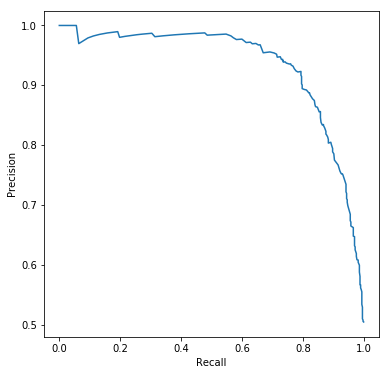

In [23]:
%matplotlib inline
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
precision, recall, _ = precision_recall_curve(test_Y, [p[1] for p in model.predict_proba(test_X)])
plt.figure(figsize=(6, 6))
plt.plot(recall, precision)
plt.xlabel('Recall')
plt.ylabel('Precision')

## Model introspection

In [24]:
# what are the most important features?
selected_clf = model.steps[-1][1].best_estimator_
feature_importances = sorted(zip(selected_clf.feature_importances_, model.steps[0][1].get_feature_names()), reverse=True)
feature_importances[:10]

[(0.05427131273198408, 'vect:proj'),
 (0.04797502942057439, 'vect:min(proj)'),
 (0.03380696992352641, 'vect:max(proj)'),
 (0.023781211055738268, 'vect:bad'),
 (0.01279503359060074, 'bow:not'),
 (0.00900958138334652, 'vect:good'),
 (0.00723409893915622, 'bow:great'),
 (0.00636432365836536, 'bow:bad'),
 (0.004503404274126933, 'delex:be|not'),
 (0.004358828067519962, 'bow:love')]

### Error analysis

To understand the mistakes made by the model, we consider instances where the model assigns a high liklihood to a label, but is wrong.

In [25]:
feature_importance_ranks = {k:i for i, (_, k) in enumerate(feature_importances)}

In [26]:
# for each mistake, we have lots of features but generally only need to see the most important ones to interpret decisions
def get_top_features(features, limit=10):
    return sorted(features.keys(), key=lambda k: feature_importance_ranks.get(k, len(feature_importance_ranks)))[:limit]

mistakes = []
for item, label, probs in zip(test, test_Y, model.predict_proba(test_X)):
    if label != numpy.argmax(probs):
        mistakes.append((numpy.max(probs), LABEL_MAP[item['label']], item['sentence'], get_top_features(item['features'])))
sorted(mistakes, reverse=True)[:10]

[(0.98,
  'negative',
  'Excellent starter wireless headset.',
  ['vect:proj',
   'vect:min(proj)',
   'vect:max(proj)',
   'vect:bad',
   'vect:good',
   'vect:direction',
   'bow:excellent',
   'bow:.',
   'delex:NOUN|.',
   'bow:headset']),
 (0.95,
  'positive',
  'Because both ears are occupied, background is not distracting at all.',
  ['vect:proj',
   'vect:min(proj)',
   'vect:max(proj)',
   'vect:bad',
   'bow:not',
   'vect:good',
   'delex:be|not',
   'bow:be|not',
   'vect:direction',
   'bow:at']),
 (0.945,
  'negative',
  'The loudspeaker option is great, the bumpers with the lights is very ... appealing.',
  ['vect:proj',
   'vect:min(proj)',
   'vect:max(proj)',
   'vect:bad',
   'vect:good',
   'bow:great',
   'vect:direction',
   'bow:the',
   'bow:.',
   'bow:,']),
 (0.94,
  'positive',
  'This fixes all the problems.',
  ['vect:proj',
   'vect:min(proj)',
   'vect:max(proj)',
   'vect:bad',
   'vect:good',
   'vect:direction',
   'bow:the',
   'bow:.',
   'bow:this',